In [67]:
# Import all necessary libraries.
import numpy as np
from scipy.special import erfc
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier

In [68]:
#16QAM Symbols
mapping_table = [-3-3j, -3-1j, -3+3j, -3+1j, -1-3j, -1-1j, -1+3j, -1+1j, 3-3j, 3-1j, 3+3j, 3+1j, 1-3j, 1-1j, 1+3j, 1+1j]

#Function to modulate 16QAM symbols
def mod(bits):
    symbols = np.zeros((len(bits),),dtype=complex)
    for i in range(0,len(bits)): symbols[i] = mapping_table[bits[i]]/np.sqrt(10)
    return symbols

In [69]:
# Instantiate a KNeighbors classifier for each one of the parts of a 16QAM symbol.
knn = KNeighborsClassifier(n_neighbors=42, weights='distance')

In [70]:
N = 100000

# Generate N 4-bit symbols.
bits = np.random.randint(0,16,N)

# Modulate the binary stream into 16QAM symbols.
symbols = mod(bits)

symbols = symbols.reshape(-1,1)
EsN0dB = np.arange(0,22,2)

ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))

for idx in range(0,len(EsN0dB)):
    print('Es/N0 dB:', EsN0dB[idx])
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    
    # Generate noise vector with unitary variance.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
    # Pass symbols through AWGN channel.
    symbols_noise = symbols + np.sqrt(EsN0Lin)*noise
    SNr = symbols_noise.real
    SNi = symbols_noise.imag
    S_noise = np.c_[SNr, SNi]
    
    Sr = symbols.real
    Si = symbols.imag
    S = np.c_[Sr, Si]
    
    clf = KNeighborsClassifier(10, weights='distance')
    
    
    clf.fit(S, bits)
    bits_pred = clf.predict(S_noise)
    bits_pred = bits_pred.reshape(N,1)
    
    error=0
    for i in range(0,N):
        if(bits_pred[i] == bits[i]):
            error = error
        else:
            error = error + 1
    
    ser_simu[idx] = 1.0 * error / N

    
    # BER teórica 16 QAM.
    M = 16
    k = np.sqrt(3/(2*(M-1)))
    ser_theo[idx] = (2*(1-(1/np.sqrt(M)))*erfc(k*np.sqrt(10.0**(EsN0dB[idx]/10.0))))-((1-(2/np.sqrt(M))+(1/np.sqrt(M)))*erfc(k*np.sqrt(10.0**(EsN0dB[idx]/10.0)))**2)
    

Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


In [71]:
for i in range(0,len(ser_simu)): print('Es/N0:%d \t- SER: %e' % (EsN0dB[i], ser_simu[i]))

Es/N0:0 	- SER: 7.404900e-01
Es/N0:2 	- SER: 6.741300e-01
Es/N0:4 	- SER: 5.871700e-01
Es/N0:6 	- SER: 4.819800e-01
Es/N0:8 	- SER: 3.534700e-01
Es/N0:10 	- SER: 2.223600e-01
Es/N0:12 	- SER: 1.100100e-01
Es/N0:14 	- SER: 3.783000e-02
Es/N0:16 	- SER: 7.580000e-03
Es/N0:18 	- SER: 5.000000e-04
Es/N0:20 	- SER: 1.000000e-05


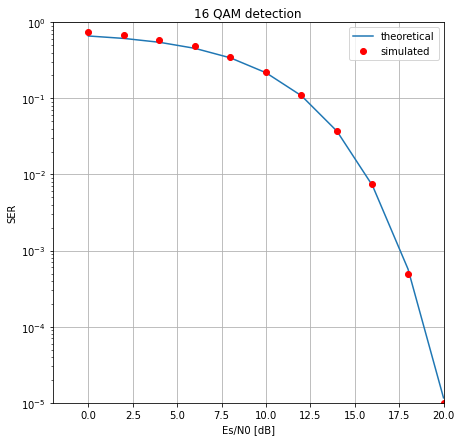

In [72]:
fig = plt.figure(figsize=(7,7))
plt.plot(EsN0dB, ser_theo, label='theoretical')
plt.plot(EsN0dB, ser_simu, 'ro', label='simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('16 QAM detection')
plt.legend()
plt.xlim([-2, 20])
plt.ylim([1e-5, 1])
plt.show()


# C. Podemos dizer que a curva simulada se aproxima da curva teórica da SER?

# Sim, a curva se aproxima muito bem.